## Stacking Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.svm import SVC
import sklearn.externals
import joblib 

In [2]:
df_train = pd.read_csv("statistics_10_train.csv" , sep = ',')
df_test = pd.read_csv("statistics_10_test.csv" , sep = ',')

In [3]:
X_train = df_train[['Kurtosis', 'Impulse factor', 'RMS', 'Margin factor', 'Skewness',
               'Shape factor', 'Peak to peak', 'Crest factor']].values
y_train = df_train['Tipo'].values
X_test = df_test[['Kurtosis', 'Impulse factor', 'RMS', 'Margin factor', 'Skewness',
               'Shape factor', 'Peak to peak', 'Crest factor']].values
y_test = df_test['Tipo'].values

In [4]:
def get_models():
    models = dict()
    models['rf'] = RandomForestClassifier(n_estimators = 90, min_samples_split = 2, min_samples_leaf  = 1)
    models['knn'] = KNeighborsClassifier(5)
    models['cart'] = tree.DecisionTreeClassifier(max_depth = 7)
    param_grid = {'C': [1E2, 5E2, 1E3, 5E3, 1E4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
    grid.fit(X_train, y_train)
    clf = grid.best_estimator_
    models['svm'] = clf
    return models

In [5]:
param_grid = {'C': [1E2, 5E2, 1E3, 5E3, 1E4],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)
grid.fit(X_train, y_train)
clf = grid.best_estimator_
    
estimators = [
     ('rf', RandomForestClassifier(random_state=0, n_estimators = 90, min_samples_split = 2, min_samples_leaf  = 1)),
     ('svm', clf),
     ('tree', tree.DecisionTreeClassifier(random_state=0, max_depth = 7)),
     ('knn',  KNeighborsClassifier(5))]
stackingClass = StackingClassifier(
    estimators=estimators, 
    final_estimator=RandomForestClassifier(n_estimators = 90, min_samples_split = 2, min_samples_leaf  = 1))
stackingClass

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=90,
                                                       random_state=0)),
                               ('svm',
                                SVC(C=500.0, class_weight='balanced',
                                    gamma=0.01)),
                               ('tree',
                                DecisionTreeClassifier(max_depth=7,
                                                       random_state=0)),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=RandomForestClassifier(n_estimators=90))

In [6]:
stackingClass.fit(X_train, y_train).score(X_test, y_test)

0.9777777777777777

In [7]:
pred = stackingClass.predict(X_test)

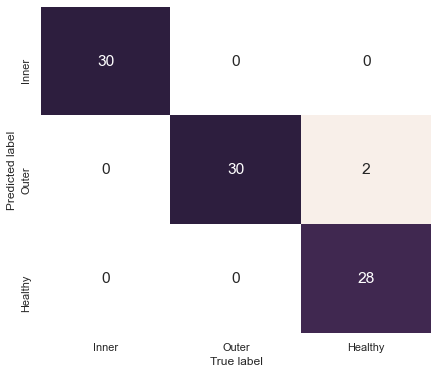

In [8]:
sns.set()
mat = confusion_matrix(y_test, pred)
fig, ax = plt.subplots(figsize=(7,6))
sns.set(font_scale=1.3)
sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=['Inner', 'Outer', 'Healthy'],
            yticklabels=['Inner', 'Outer', 'Healthy'],
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))

plt.xlabel('True label');
plt.ylabel('Predicted label');

In [9]:
fig.savefig('stacking_test.png')

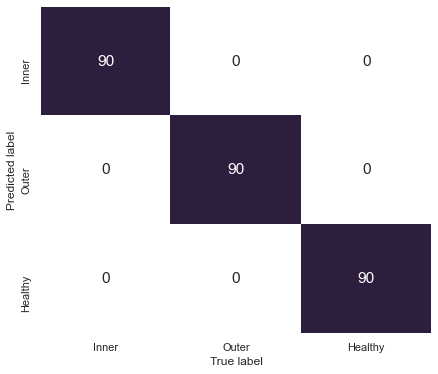

In [10]:
sns.set()
mat = confusion_matrix(y_train, stackingClass.predict(X_train))
fig, ax = plt.subplots(figsize=(7,6))
sns.set(font_scale=1.3)
sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=['Inner', 'Outer', 'Healthy'],
            yticklabels=['Inner', 'Outer', 'Healthy'],
            cmap=sns.cubehelix_palette(light=1, as_cmap=True))

plt.xlabel('True label');
plt.ylabel('Predicted label');

In [11]:
pred_train = stackingClass.predict(X_train)
pred_test = stackingClass.predict(X_test)
print(classification_report(y_train, pred_train))
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

       Inner       1.00      1.00      1.00        90
       Outer       1.00      1.00      1.00        90
        Sano       1.00      1.00      1.00        90

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

              precision    recall  f1-score   support

       Inner       1.00      1.00      1.00        30
       Outer       0.94      1.00      0.97        30
        Sano       1.00      0.93      0.97        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [12]:
fig.savefig('stacking_train.png')

#### Locate the signals that fail:

In [13]:
posFallos = []
for i in range(len(pred)):
    if pred[i] != y_test[i]:
        posFallos.append(i)
        
posFallos

[63, 64]

In [14]:
df_test[60:70]

,Tipo,Kurtosis,Impulse factor,RMS,Margin factor,Skewness,Shape factor,Peak to peak,Crest factor
60,Sano,2.881604,9.519276,2.160481,0.006647,-0.051708,662.892027,0.058745,0.014360
61,Sano,2.570253,8.950549,2.042949,0.006650,0.047749,658.849097,0.051800,0.013585
62,Sano,2.834096,9.552926,1.884463,0.007685,0.007942,659.618030,0.052550,0.014483
63,Sano,3.775927,11.648928,1.872356,0.009289,-0.116130,669.802485,0.058845,0.017392
64,Sano,5.075071,15.746345,1.672984,0.014049,0.103113,669.969475,0.071987,0.023503
65,Sano,2.655643,9.026857,1.429398,0.009641,0.133299,654.999143,0.037297,0.013781
66,Sano,2.512052,10.033075,1.304254,0.011786,0.057131,652.669820,0.037986,0.015372
67,Sano,2.940255,10.449484,1.535291,0.010364,0.157920,656.738875,0.047567,0.015911
68,Sano,2.791382,10.477160,1.736299,0.009231,0.062116,653.693128,0.052311,0.016028
69,Sano,2.543773,10.020533,1.821577,0.008446,0.032525,651.344530,0.050487,0.015384


In [15]:
import scipy.io as sio
signals_test_mat = sio.loadmat('signals_test.mat')
X_test36 = signals_test_mat['Signal']
y_test36 = signals_test_mat['Tipo']

In [16]:
fault_signal = X_test36[6]
fault_signal

array([ 0.00470634,  0.01062559,  0.01062559, ...,  0.00207557,
       -0.02193027, -0.00088406])

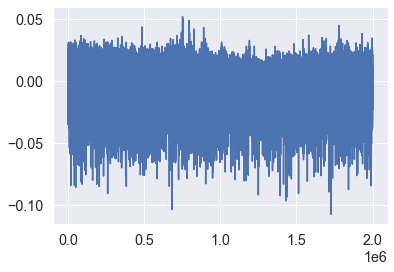

In [17]:
plt.plot(fault_signal)

2.8816036941883656 9.519275808402567 2.1604812667453714 0.006646769364587931 -0.051707942316864215 662.8920271870735 0.05874488568510781 0.01436022069656926
2.570252974531818 8.950549328573763 2.0429492893731167 0.006649762717359153 0.047749361807244824 658.8490970980498 0.051800301945464096 0.013585128017928728
2.8340957588104976 9.55292589158497 1.88446283871375 0.007685220148249022 0.007941533447929973 659.6180302748195 0.05254951169017931 0.014482511776709459
3.7759270775245497 11.648927770919007 1.8723562288434337 0.009288609776994994 -0.11612997282028578 669.8024850012813 0.058845447189082134 0.017391586373252596
5.075070736633249 15.746345308002446 1.6729840427608818 0.01404859707191971 0.10311342915681129 669.9694747475323 0.07198667777965663 0.023503078724498923
2.6556429613674064 9.02685681976841 1.4293977701536635 0.009641458178414873 0.13329854490694645 654.9991431867046 0.03729662253821922 0.013781478821256023
2.5120516580947587 10.033074995661883 1.3042535317767614 0.0117

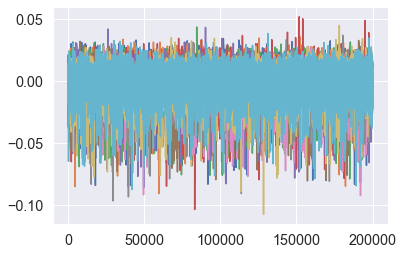

In [18]:
import statistics_hamming
from statistics_hamming import *
for j in range(10):
    signal = fault_signal[200000 * j : 200000 * (j+1)]
    plt.plot(signal)
    kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor = parameters_hamming(signal)
    print(kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor)

3.7759270775245497 11.648927770919007 1.8723562288434337 0.009288609776994994 -0.11612997282028578 669.8024850012813 0.058845447189082134 0.017391586373252596
5.075070736633249 15.746345308002446 1.6729840427608818 0.01404859707191971 0.10311342915681129 669.9694747475323 0.07198667777965663 0.023503078724498923


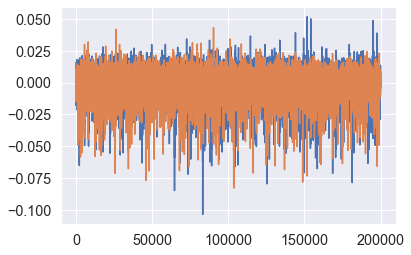

In [19]:
for j in range(3, 5):
    signal = fault_signal[200000 * j : 200000 * (j+1)]
    plt.plot(signal)
    kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor = parameters_hamming(signal)
    print(kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor)

2.6556429613674064 9.02685681976841 1.4293977701536635 0.009641458178414873 0.13329854490694645 654.9991431867046 0.03729662253821922 0.013781478821256023
2.5120516580947587 10.033074995661883 1.3042535317767614 0.01178632755206852 0.057131178227727265 652.6698196459347 0.037986317305216594 0.015372359336463118


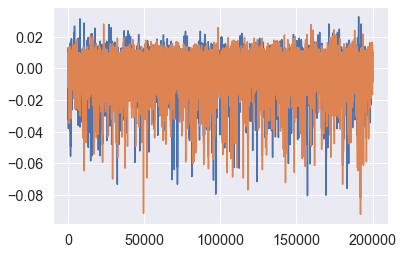

In [20]:
for j in range(5, 7):
    signal = fault_signal[200000 * j : 200000 * (j+1)]
    plt.plot(signal)
    kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor = parameters_hamming(signal)
    print(kurt, impulse_factor, RMS, margin_factor, skewness, shape_factor, peak_to_peak, crest_factor)